# Considerations for this section

- Before building a classification model, let’s build a Dummy Classifier to determine the ‘baseline’ performance. This answers the question — ‘What would be the success rate of the model, if one were simply guessing?’ The dummy classifier we are using will simply predict the majority class.
- Determine differences between oversampling and undersampling
- Explain the evaluation metric we chose (A false negative is more serious as a disease has been ignored, which can lead to the death of the patient. At the same time, a false positive would lead to an unnecessary treatment — incurring additional cost.)
- Report the results and measurements in a good way
- Explain the model tuning we did (GridSearch e.g.)
- Compare model before and after tuning

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')
# https://www.kaggle.com/fedesoriano/stroke-prediction-dataset 
df = pd.read_csv("..\\..\\data\\healthcare-dataset-stroke-data.csv")

In [18]:
# Fill missing values
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

DecisionTreePip = Pipeline(steps=[ 
                               ('Scale',StandardScaler()),
                               ('DecisionTreeReg',DecisionTreeRegressor(random_state = 42))
                              ])

X = df[['age','gender','bmi']]
X.gender = X.gender.replace({'Male' : 0, 'Female' : 1 , 'Other' : -1}).astype(np.uint8)

# create a dataframe containing the missing values of X
missing = X[X.bmi.isna()]

# remove the missing values from X 
X = X.dropna()

# creates Y by removing bmi from X
Y = X.pop('bmi')

# fit the pipeline
DecisionTreePip.fit(X,Y)

# make the prediction 
predict_bmi = pd.Series(DecisionTreePip.predict(missing[['age', 'gender']]), index = missing.index)
df.loc[missing.index, 'bmi'] = predict_bmi

C:\Users\laise\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [19]:
# Generate the data samples: Original, Oversampled, Undersampled
y = df[["stroke"]].copy()
X = df.copy()

In [20]:
# ALWAYS SPLIT THE DATA IN TRAIN AND TEST AND THEN OVERSAMPLE/DOWNSAMPLE
# see here: https://stackoverflow.com/questions/48805063/balance-classes-in-cross-validation/48810493#48810493 
from sklearn.model_selection import train_test_split
# Split data
X_raw_train, X_test, y_raw_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3, shuffle=True) # Set shuffle to true to have data of both labels in test set

In [21]:
X_raw_train.drop(["id", "stroke"], inplace=True, axis=1)
X_test.drop(["id", "stroke"], inplace=True, axis=1)

C:\Users\laise\anaconda3\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [22]:
# The oversampled/undersampled data will be used for training ONLY! not for testing

from src.Resample import undersample_kmeans
from src.Resample import oversample

df_input = X_raw_train.copy()
df_input["stroke"] = y_raw_train

# Get over and undersampled data
undersampled = undersample_kmeans(df_input)
oversampled = oversample(df_input)

y_over_train = oversampled[["stroke"]].copy()
y_under_train = undersampled[["stroke"]].copy()

oversampled.drop(columns=["stroke"], inplace=True)
undersampled.drop(columns=["stroke"], inplace=True)

X_over_train = oversampled.copy()
X_under_train = undersampled.copy()
X_under_train = X_under_train[["gender","age","hypertension","heart_disease","ever_married","work_type","Residence_type","avg_glucose_level","bmi","smoking_status"]] # Only do this because column order must be same as X_test column order!

Original dataset samples per class Counter({0: 3643, 1: 189})
Resampled dataset samples per class Counter({0: 189, 1: 189})
Original dataset samples per class Counter({0: 3643, 1: 189})
Resampled dataset samples per class Counter({0: 3643, 1: 1202})


In [60]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


num_pipe = Pipeline([
    #('impute', SimpleImputer(strategy='median', copy=False)),
    #('minmax_scaler', MinMaxScaler(copy=False))
    #('standard_scaler', StandardScaler(copy=False))
    ('robust_scaler', RobustScaler(copy=False))
])

ordinal_pipe = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

binary_pipe = Pipeline([
    ('label_encoder', OrdinalEncoder()),
])

# two pipelines combined in the column transformer
full_transform = ColumnTransformer([
    ("num", num_pipe, ["age", "avg_glucose_level", "bmi"]),
    ("ord", ordinal_pipe, ["gender", "work_type", "smoking_status"]),
    ("binary", binary_pipe, ["ever_married", "Residence_type"]),
])

full_pipeline_with_model = Pipeline([
    ('trf', full_transform),
    ('svm', SVC(C= 0.09, class_weight= 'balanced', kernel= 'linear'))
])

full_pipeline_no_model = Pipeline([
    ('trf', full_transform),
])

In [ ]:
# Evaluate model
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [24]:
# Fit model/pipeline on TRAINING DATA; On either Oversampled, Undersampled, or Original data
full_pipeline_with_model.fit(X_raw_train, y_raw_train.values.flatten())

y_pred = full_pipeline_with_model.predict(X_test)

# KFold cross validation
cv = KFold(n_splits=3, random_state=None)
accuracies = cross_val_score(estimator = full_pipeline_with_model, X = X_over_train, y = y_over_train.values.flatten(), cv = cv) # Set input here! Over, under or original data. Only training data!

cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

stroke_recall = cm[1][1]/cm[1].sum()
stroke_cases = len(y_test[y_test["stroke"]==1])
'''
Most important metric we want to look for is the percentage of actual positives that we have identified.
This corresponds to HIGH Recall for Stroke True Positive (Recall = Percantage of accurately identified positives)
'''
print('Confusion Matrix')
print("There are {} stroke cases in test set".format(stroke_cases))
print(cm)
print("The Recall of Stroke is: {:.2f} %".format(stroke_recall*100))
print('')
print("The General Recall is: {:.2f} %".format(recall*100))
print('')
print('Accuracy Score: ',accuracy_score(y_test, y_pred))
print('')
print("K-Fold Validation Mean Accuracy: {:.2f} %".format(accuracies.mean()*100))
print('')
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))
print('')
print('Precision: {:.2f}'.format(precision))
print('')
print('Recall: {:.2f}'.format(recall))
print('')
print('F1: {:.2f}'.format(f1))
print('-----------------------------------')

Confusion Matrix
There are 60 stroke cases in test set
[[825 393]
 [  8  52]]
The Recall of Stroke is: 86.67 %

The General Recall is: 86.67 %

Accuracy Score:  0.6862284820031299

K-Fold Validation Mean Accuracy: 74.72 %

Standard Deviation: 4.99 %

Precision: 0.12

Recall: 0.87

F1: 0.21
-----------------------------------


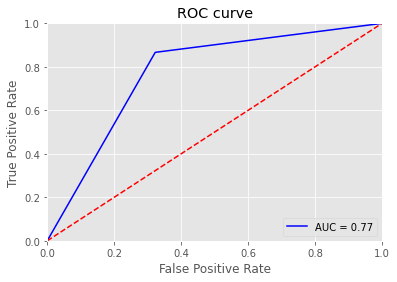

In [25]:
# ROC curve
# code inspired from https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/?fbclid=IwAR0g5dlUGF53mbQQ0h9kwV8Ne9-NzYiGjlYwe72GpHbidMEEPAUD2Sgu1yo
import sklearn.metrics as metrics
# import scikitplot as skplt
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('ROC curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Grid Search

### Evaluation Metric Discussion

If your dataset is heavily imbalanced and/or you mostly care about the positive class, I’d consider using F1 score, or Precision-Recall curve and PR AUC.  The additional reason to go with F1 (or Fbeta) is that these metrics are easier to interpret and communicate to business stakeholders.
(https://neptune.ai/blog/f1-score-accuracy-roc-auc-pr-auc)

As a rule of thumb, if the cost of having False negative is high, we want to increase the model sensitivity and recall (which are the exact same in regard to their formula)!.
For instance, in fraud detection or sick patient detection, we don't want to label/predict a fraudulent transaction (True Positive) as non-fraudulent (False Negative). Also, we don't want to label/predict a contagious sick patient (True Positive) as not sick (False Negative).
This is because the consequences will be worse than a False Positive (incorrectly labeling a a harmless transaction as fraudulent or a non-contagious patient as contagious). (https://stackoverflow.com/questions/44172162/f1-score-vs-roc-auc)

--> Consequently, when you have a data imbalance between positive and negative samples, you should always use F1-score because ROC averages over all possible thresholds!!

In [89]:
# Use f1 beta score that emphasizes recall more

from sklearn.metrics import fbeta_score, make_scorer

f1 = make_scorer(fbeta_score , beta=2) # With beta of 

### Multiple models

In [90]:
# Do parameter tuning
# The GridSearchCV is a library function that is a member of sklearn's model_selection package. It helps to loop through predefined hyperparameters and fit your estimator (model) on your training set. So, in the end, you can select the best parameters from the listed hyperparameters.
# This implementation is to compare several different models. By default, the GridSearchCV uses a 5-fold cross-validation
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


grid_models = [(LogisticRegression(),[{'C':[0.25,0.5,0.75,1],'random_state':[0], "penalty": ["l2", 'none'],  'class_weight': [None, 'balanced']}]), 
               (SVC(),[{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.001,.009,0.01,.09,1,5,10,25], 'class_weight': [None, 'balanced']}])]


# Perform on the oversampled and raw data respectively
for data in ["raw", "over"]:

    # Get training X and y of either raw or oversampled data 
    X = globals()[f"X_{data}_train"]
    y = globals()[f"y_{data}_train"]
    
    X_transformed = full_pipeline_no_model.fit_transform(X)

    for i,j in grid_models:
        grid = GridSearchCV(estimator = i, param_grid = j, scoring = f1) # use F1 as evaluation metric
        grid.fit(X_transformed, y.values.flatten())
        # Transform test values
        X_transformed_test = full_pipeline_no_model.transform(X_test) 
        # Get predictions  
        y_pred_acc = grid.predict(X_transformed_test)
        # Get optimal values
        best_accuracy = grid.best_score_
        best_param = grid.best_params_
        print(f"Looking at {data} data!")
        print('----------------')
        print('{}:\nBest F1 : {:.2f}%'.format(i,best_accuracy*100))
        #Logistic Regression (Grid Search) Confusion matrix
        print(confusion_matrix(y_test,y_pred_acc))
        print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
        print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
        print('Best Parameters : ', best_param)
        print('')
        print('----------------')
        print('')


Looking at raw data!
----------------
LogisticRegression():
Best F1 : 40.14%
[[868 350]
 [ 13  47]]
Precision Score : 0.11838790931989925
Recall Score : 0.7833333333333333
Best Parameters :  {'C': 0.75, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 0}

----------------

Looking at raw data!
----------------
SVC():
Best F1 : 40.05%
[[853 365]
 [  9  51]]
Precision Score : 0.12259615384615384
Recall Score : 0.85
Best Parameters :  {'C': 25, 'class_weight': 'balanced', 'kernel': 'linear'}

----------------

Looking at over data!
----------------
LogisticRegression():
Best F1 : 75.78%
[[901 317]
 [ 17  43]]
Precision Score : 0.11944444444444445
Recall Score : 0.7166666666666667
Best Parameters :  {'C': 0.5, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 0}

----------------

Looking at over data!
----------------
SVC():
Best F1 : 80.59%
[[992 226]
 [ 39  21]]
Precision Score : 0.08502024291497975
Recall Score : 0.35
Best Parameters :  {'C': 10, 'class_weight': 

### Single model

In [52]:
# Use f1 beta score that emphasizes recall more

from sklearn.metrics import fbeta_score, make_scorer

f1 = make_scorer(fbeta_score , beta=1)

In [67]:
# This GridSearch version is just for a single model

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

model = SVC()

scores = ["precision", "recall"]

# Transform the input data before fitting it to GridSearch
X_transformed = full_pipeline_no_model.fit_transform(X_raw_train)

# Extensive test
grid_values = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'C':[0.001,.009,0.01,.09,1,5,10,25], 'class_weight': [None, 'balanced']}

# Small test
# grid_values = {'kernel': ['linear'],'C':[0.001], 'class_weight': [{1: 0.2, 0:0.8}, {1: 0.4, 0: 0.6}, {1: 0.8, 0 :0.2}]}
# grid_values = {'kernel': ['linear'],'C':[0.001, 0.01], 'class_weight': [None, 'balanced']}

grid_clf_acc = GridSearchCV(model, param_grid = grid_values, scoring = 'f1') # Take custom scorer
grid_clf_acc.fit(X_transformed, y_raw_train.values.flatten())

# Transform test values
X_transformed_test = full_pipeline_no_model.transform(X_test)

#Predict values based on new parameters
y_pred_acc = grid_clf_acc.predict(X_transformed_test)

# New Model Evaluation metrics 
print('Accuracy Score : ' + str(accuracy_score(y_test,y_pred_acc)))
print('Precision Score : ' + str(precision_score(y_test,y_pred_acc)))
print('Recall Score : ' + str(recall_score(y_test,y_pred_acc)))
print('F1 Score : ' + str(f1_score(y_test,y_pred_acc)))
print('ROC_AUC: ' + str(roc_auc_score(y_test, y_pred_acc)))

#Logistic Regression (Grid Search) Confusion matrix
print(confusion_matrix(y_test, y_pred_acc))

best_param = grid_clf_acc.best_params_

print('Best Parameters : ', best_param)

Accuracy Score : 0.8255086071987481
Precision Score : 0.1471861471861472
Recall Score : 0.5666666666666667
F1 Score : 0.2336769759450172
ROC_AUC: 0.7024630541871921
[[1021  197]
 [  26   34]]
Best Parameters :  {'C': 0.009, 'class_weight': 'balanced', 'kernel': 'poly'}


In [74]:
X_transformed_test[5]

array([0.55555556, 0.21167733, 0.09042553, 1.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       1.        , 0.        ])